In [1]:
from pokerkit import *
import numpy as np
from tqdm import tqdm
import copy
from concurrent.futures import ProcessPoolExecutor

# Environment
from environment import PokerEnvironment

# Visualizations
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from frozendict import frozendict
from collections import deque

# Hardcode possible actions
ACTIONS = ['fold','check_or_call','quarter_pot','half_pot','pot','two_pot','all_in']

In [2]:
# class PokerEnvironment:
#     def __init__(self, config):
#         self.config = config
#         self.n_samples = config['monte_carlo_sample_size']

#         # Start hand
#         self.game_state = NoLimitTexasHoldem.create_state(
#             automations=(
#                 Automation.ANTE_POSTING,
#                 Automation.BET_COLLECTION,
#                 Automation.BLIND_OR_STRADDLE_POSTING,
#                 Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
#                 Automation.HAND_KILLING,
#                 Automation.CHIPS_PUSHING,
#                 Automation.CHIPS_PULLING
#             ),
#             ante_trimming_status=False,
#             raw_antes=0,
#             raw_blinds_or_straddles=(1,2),
#             min_bet=2,
#             raw_starting_stacks=(self.config['player_0_stack'], self.config['player_1_stack']),
#             player_count=2,
#             mode = Mode.CASH_GAME
#         )

#         # Initialize Variables
#         self.raises = [0, 0]
#         self.calls = [0, 0]
#         self.played_hands = [0, 0]
#         self.total_hands = 0

#         self.last_pot_size = -999
#         self.is_complete = False
#         self.has_played_current_hand = [False, False]
#         self.hand_state = 0
#         self.total_hands += 1
#         # Deal Preflop Cards
#         for i in range(4):
#             self.game_state.deal_hole()
#         self.pot_size = self.game_state.total_pot_amount


#     def reset(self):
#         stacks = self.game_state.stacks
#         if self.stack[0] == 0:
#             print('PLAYER 0 RAN OUT OF MONEY')
#             stacks[0] = self.config['player_0_stack']
#         elif self.stack[1] == 0:
#             print('PLAYER 1 RAN OUT OF MONEY')
#             stacks[1] = self.config['player_1_stack']
#         else:
#             self.game_state = NoLimitTexasHoldem.create_state(
#                 automations=(
#                     Automation.ANTE_POSTING,
#                     Automation.BET_COLLECTION,
#                     Automation.BLIND_OR_STRADDLE_POSTING,
#                     Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
#                     Automation.HAND_KILLING,
#                     Automation.CHIPS_PUSHING,
#                     Automation.CHIPS_PULLING
#                 ),
#                 ante_trimming_status=False,
#                 raw_antes=0,
#                 raw_blinds_or_straddles=(1,2),
#                 min_bet=2,
#                 raw_starting_stacks=(stacks[0], stacks[1]),
#                 player_count=2,
#                 mode = Mode.CASH_GAME
#             )

#             self.last_pot_size = -999
#             self.is_complete = False
#             self.has_played_current_hand = [False, False]
#             self.hand_state = 0
#             self.total_hands += 1
#             # Deal Preflop Cards
#             for i in range(4):
#                 self.game_state.deal_hole()
#             self.pot_size = self.game_state.total_pot_amount


        
#     def get_state(self, player_index):
#         if player_index < 0 or player_index > 1 :
#             raise Exception('Player Index can only be 0 or 1')
#         hand = self.game_state.hole_cards[player_index]
#         board = self.game_state.board_cards
#         hand_strength = self._calculate_hand_strength(hand, board, self.n_samples)
#         # TODO:: Hand Potential
#         hand_state = self.hand_state # are we preflop, flop, turn, or river
#         bets = self.game_state.bets
#         pot_size = self.pot_size
#         if player_index == 0:
#             money_to_call = max(bets[1] - bets[0], 0)
#             stack = self.game_state.stacks[0]
#             af = self._calculate_af(self.raises[1], self.calls[1]) # calculate player 1's af
#             lh = self._calculate_lh(self.played_hands[1])
#         else:
#             money_to_call = max(bets[0] - bets[1], 0)
#             stack = self.game_state.stacks[1]
#             af = self._calculate_af(self.raises[0], self.calls[0]) # calculate player 0's af
#             lh = self._calculate_lh(self.played_hands[0])
        
#         return {'stack': stack,
#                 'pot_size': pot_size,
#                 'money_to_call': money_to_call,
#                 'hand_strength': hand_strength,
#                 'af': af,
#                 'lh': lh,
#                 'hand_state': hand_state,
#                 'done': self.is_complete}
    

#     def _calculate_af(self, raises, calls):
#         if calls == 0:
#             af = -1
#         else:
#             af = raises / calls
#         return af
    
#     def _calculate_lh(self, played_hands):
#         if self.total_hands < 10:
#             lh = 1#0.75
#         else:
#             lh = played_hands / self.total_hands
#         return lh
    

#     def _calculate_hand_strength(self, hand, board, n_samples):
#         hand = frozenset([frozenset(hand)])
#         #print(hand)
#         board = frozenset([x[0] for x in board])
#         #print(board)
#         strength = calculate_hand_strength(
#             player_count= 2,
#             hole_range = hand,
#             board_cards = board,
#             hole_dealing_count=2,
#             board_dealing_count=5,
#             deck=Deck.STANDARD,
#             hand_types=(StandardHighHand,),
#             sample_count=n_samples,
#             #executor=executor
#         )
#         return strength


#     def _calculate_hand_potential(self, hand, board, n_samples):
#         return 0.5
    

#     def _calculate_opponent_hand_potential(self, your_hand, board, outer_sim_samples, inner_sim_samples):
#         potentials = list()
#         for i in range(outer_sim_samples):
#             potentials.append(self._calculate_hand_potential(your_hand, board, inner_sim_samples))
#         return np.mean(potentials)


#     def step(self, action, player_index):
#         self.is_complete = False

#         # Handle Folds
#         if not action['fold']:
#             self.has_played_current_hand[player_index] = True
#         else:
#             self.game_state.fold()
#             self.is_complete = True

#         # Handle Checks or Calls 
#         if action['check_or_call']:
#             output = self.game_state.check_or_call()
#             self.calls[player_index] += 1
#             self.pot_size += output.amount

#         # Handle Raises
#         if action['raise']:
#             output = self.game_state.complete_bet_or_raise_to(action['bet_size'])
#             self.raises[player_index] += 1
#             self.pot_size += output.amount

        
#         # Check if game is over
#         is_player_0_in_hand = self.game_state.statuses[0]
#         is_player_1_in_hand = self.game_state.statuses[1]
#         if not (is_player_0_in_hand and is_player_1_in_hand):
#             self.is_complete = True

#         # Handle if players are all in
#         if self.game_state.all_in_status:
#             self.select_runout_count(1)
#             self.select_runout_count(1)
#             while self.game_state.can_burn_card():
#                 self.hand_state += 1
#                 self.game_state.burn_card()
#                 self.game_state.deal_board()
#             self.is_complete = True

#         if self.is_complete:
#             if self.has_played_current_hand[0]:
#                 self.played_hands[0] += 1
#             if self.has_played_current_hand[1]:
#                 self.played_hands[1] += 1
            

#         # Increment hand state
#         if self.game_state.can_burn_card():
#             self.hand_state += 1
#             self.game_state.burn_card()
#             self.game_state.deal_board()
        
#         return self.is_complete


#     def reward(self, state, player_index):
#         # Handle reward if user won/lost
#         if state['done']:
#             did_win = self.game_state.statuses[player_index]
#             if did_win:
#                 return state['pot_size']
#             else:
#                 return -1 * state['pot_size']
#         # Handle reward if mid hand
#         epsilon = 0.001
#         return ((state['hand_strength'] ** (1/(state['lh'] + epsilon))) - (1 - (state['hand_strength'] ** (1/(state['lh'] + epsilon))))) * state['pot_size']

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)    #First fully connected layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)    #Second fully connected layer
        self.fc3 = nn.Linear(hidden_size, 1)    #Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))    #ReLU activation for the first layer
        x = F.relu(self.fc2(x))    #ReLU activation for the second layer
        x = self.fc3(x)    #Output layer (no activation because this is a regression problem)
        return x

In [4]:
class BaseAgent:
    def __init__(self, config):
        self.config = config
    
    def clean_action(self, raw_action, state, min_bet_size, can_raise_func, can_fold):
        """
        Clean's agent's action into something the environment can handle
        """               
        action_dict = {'fold':False,'check_or_call':False,'raise':False,'bet_size':-999}
        if type(raw_action) is list:
            raw_action = raw_action[0]
        match raw_action:
            case 'fold':
                if can_fold:
                    action_dict['fold'] = True
                else:
                    action_dict['check_or_call'] = True
                    raw_action = 'check_or_call'
                return action_dict, raw_action
            case 'check_or_call':
                action_dict['check_or_call'] = True
                return action_dict, raw_action
            case 'quarter_pot':
                bet_size = min(max(state[1]*.25, min_bet_size), state[0]) # Index 1 is pot size, index 0 is stack
                if can_raise_func(bet_size):
                    action_dict['raise'] = True
                    action_dict['bet_size'] = bet_size
                else:
                    action_dict['check_or_call'] = True
                return action_dict, raw_action
            case 'half_pot':
                bet_size = min(max(state[1]*.5, min_bet_size), state[0])
                if can_raise_func(bet_size):
                    action_dict['raise'] = True
                    action_dict['bet_size'] = bet_size
                else:
                    action_dict['check_or_call'] = True
                return action_dict, raw_action
            case 'pot':
                bet_size = min(max(state[1], min_bet_size), state[0])
                if can_raise_func(bet_size):
                    action_dict['raise'] = True
                    action_dict['bet_size'] = bet_size
                else:
                    action_dict['check_or_call'] = True
                return action_dict, raw_action
            case 'two_pot':
                bet_size = min(max(2*state[1], min_bet_size), state[0])
                if can_raise_func(bet_size):
                    action_dict['raise'] = True
                    action_dict['bet_size'] = bet_size
                else:
                    action_dict['check_or_call'] = True
                return action_dict, raw_action
            case 'all_in':
                bet_size = state[0]
                if can_raise_func(bet_size):
                    action_dict['raise'] = True
                    action_dict['bet_size'] = bet_size
                else:
                    action_dict['check_or_call'] = True
                return action_dict, raw_action
            case _:
                raise Exception(f"Passed in bad raw action: {raw_action}")


In [5]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size) #using a deque instead of a list should speed up computation as popping at index 0 many times is computationally expensive for a list
            # Adding maxlen for deque also automatically handles popping when full
    def append(self, transition):
        self.buffer.append(transition)
    def batch(self, batch_size):
        batch_size = min(len(self.buffer), batch_size) # make sure we aren't sampling more than there is in buffer
        ret_batch = np.random.choice(self.buffer, batch_size)
        return ret_batch, np.arange(len(ret_batch))
    def extend(self, transitions):
        for transition in transitions:
            self.buffer.append(transition)

class PrioritizedReplayBuffer:
    def __init__(self, buffer_size, beta, epsilon):
        self.buffer = deque(maxlen=buffer_size) # Using a deque instead of a list should speed up computation as popping at index 0 many times is computationally expensive for a list
                                                # Adding maxlen for deque also automatically handles popping when full
        self.priorities = deque(maxlen=buffer_size)
        self.beta = beta
        self.epsilon = epsilon

    def append(self, transition):
        self.buffer.append(transition)
        #print(self.priorities)
        self.priorities.append(max(self.priorities, default=1)) #give it a high priority so it new things transitions will get trained on
    
    def extend(self, transitions):
        for transition in transitions:
            self.buffer.append(transition)
            self.priorities.append(max(self.priorities, default=1))

    def batch(self, batch_size):
        batch_size = min(len(self.buffer), batch_size) # make sure we aren't sampling more than there is in buffer
        
        #turn priority to probability
        probs = np.array(self.priorities) ** self.beta
        probs = probs / sum(probs) 

        batch_indices = np.random.choice(np.arange(len(self.buffer)), batch_size, p=probs)
        batch = np.array(self.buffer)[batch_indices]
        return batch, batch_indices

    def set_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = td_error + self.epsilon


In [6]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class DQNAgent(BaseAgent):
    '''A class to manage the agent'''
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def __init__(self, config):
        '''Set up the constructor
            Takes -- config, a dictionary specifying the track dimensions and initial state
        '''
        self.input_size = 14 # Size of state space
        #self.output_size = 7 # Size of action space
        self.config = config
        self.Q = MLP(input_size=self.input_size, hidden_size=self.config['hidden_size'])
        #self.Q.to('cuda')
        self.Q.train()    #Set the model to training mode
        self.Q_prime = copy.deepcopy(self.Q)
        self.criterion = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.Q.parameters(), lr=self.config['alpha'])
        if config['prioritizedReplay']:
            self.D = PrioritizedReplayBuffer(buffer_size=config['M'], beta=config['beta'], epsilon=config['pr_epsilon'])    #init the replay buffer
        else:
            self.D = ReplayBuffer(buffer_size=config['M'])

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def Q_reset(self):
        '''A function reset the MLP to random initial parameters'''
        self.Q = MLP(input_size=self.input_size, hidden_size=self.config['hidden_size'])
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def update_Q_prime(self):
        '''A function set the target approximator to the online network'''
        self.Q_prime = copy.deepcopy(self.Q)
    
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def make_options(self, s_t):
        '''A function to create the state action pairs
            Takes:
                s_t -- a list of the state information
            Returns:
                a torch tensor with the first six columns the state information and the last two columns the actions
        '''
        s_tA = []    #init a list to hold the state action information
        for a in self.config['A']:    #loop over actions
            # One hot enode action list
            action_idx = ACTIONS.index(a)
            action_one_hot = list(np.zeros(shape=(len(ACTIONS),)))
            action_one_hot[action_idx] = 1
            #print(f" s_t: {s_t}, a: {a}")
            s_tA.append(s_t + action_one_hot)    #add and record
            #print(f'action_one_hot: {action_one_hot}\n state: {s_t}\nstate action list: {s_tA}')
        return torch.tensor(s_tA).to(torch.float32)

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def epsilon_t(self, count, n_episodes):
        '''Lets try out a dynamic epsilon
            Takes:
                count -- int, the number of turns so far
            Returns:
                float, a value for epsilon
        '''
        if count <= self.config['epsilon_burnin']:    #if we're still in the initial period...
            return 1    #choose random action for sure
        else:
            return 1/(n_episodes**0.5)    #otherwise reduce the size of epsilon

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def policy(self, s_t, min_bet_size, can_raise_func, can_fold):
        '''A function to choose actions using Q-values
            Takes:
                s_t -- a torch tensor with the first six columns the state information and the last two columns the actions
                epsilon -- the probability of choosing a random action
        '''
        #print(f'state: {s_t}')
        if np.random.uniform() < 0.2:    #if a random action is chosen...
            return self.clean_action(self.config['A'][np.random.choice(a = range(len(self.config['A'])))],s_t,min_bet_size, can_raise_func, can_fold)    #return the random action
        else:
            return self.clean_action(self.config['A'][torch.argmax(self.Q(self.make_options(s_t)))],s_t, min_bet_size, can_raise_func, can_fold)    #otherwise return the action with the highest Q-value as predicted by the MLP
        
    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    def make_batch(self):
        '''A function to make a batch from the memory buffer and target approximator
            Returns:
                a list with the state-action pair at index 0 and the target at index 1
        '''
        batch, batch_indices = self.D.batch(batch_size=self.config['B']) #only need batch_indices if using prioritized replay
        if self.config['prioritizedReplay']:
            td_errors, indices = [], []
       # batch = np.random.choice(self.D,self.config['B'])    #sample uniformly
        X,y = [],[]    #init the state-action pairs and target
        for d, i in zip(batch, batch_indices):    #loop over all the data collected
            X.append(d['d_s_a'])    #record the state action pair
            y_t = d['r_t+1']    #compute the target
            if not d['done']:    #if this state didn't end the episode...
                state_action_tensor = self.make_options(d['s_t+1'])
                if self.config['DDQN']:
                    best_online_action = state_action_tensor[np.argmax(self.Q(state_action_tensor).detach().numpy())] # Find best action from online network
                    max_a_Q = float(self.Q_prime(best_online_action)) # Evaluate in target approximator
                else:
                    max_a_Q = float(max(self.Q_prime(state_action_tensor)))    #compute the future value using the target approximator
                y_t = y_t + (self.config['gamma'] ** self.config['multi_step'])*max_a_Q    #update the target with the future value

                if self.config['prioritizedReplay']: # get temporal difference error
                    td_error = abs(y_t - self.Q_prime(torch.tensor(d['d_s_a']).to(torch.float32)).item()) # calculate td error
                    #print(td_error)
                    td_errors.append(td_error)
                    indices.append(i)
            y.append(y_t)    #record the target   
        if self.config['prioritizedReplay']:
            self.D.set_priorities(indices, td_errors)
        return [X,y]

    #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@    
    def update_Q(self,X,y):
        '''A function to update the MLP
            Takes:
                X -- the features collected from the replay buffer
                y -- the targets
        '''
        #do the forward pass
        X = torch.tensor(X).to(torch.float32)
        y = torch.tensor(y).to(torch.float32).view(len(y),1)
        outputs = self.Q(X)    #pass inputs into the model (the forward pass)
        loss = self.criterion(outputs,y)    #compare model outputs to labels to create the loss

        #do the backward pass
        self.optimizer.zero_grad()    #zero out the gradients    
        loss.backward()    #compute gradients
        self.optimizer.step()    #perform a single optimzation step


In [7]:
class CallAgent(BaseAgent):
    def policy(self, state, min_bet_size,can_raise_func, can_fold):
        return self.clean_action(self.config['A'][1], state, min_bet_size,can_raise_func, can_fold) # Index for checking/calling

In [8]:
class CallorRaiseAgent(BaseAgent):
    def policy(self, state, min_bet_size,can_raise_func, can_fold):
        if 'raise_choice' not in self.config.keys():
            raise Exception('Must Specify what strategy to raise')
        if np.random.random() < 0.5:
            return self.clean_action(self.config['A'][1], state, min_bet_size,can_raise_func, can_fold) # Index for checking/calling
        else:
            return self.clean_action(self.config['A'][self.config['raise_choice'] + 2], state, min_bet_size,can_raise_func, can_fold) # Shift so raise_choice represents the proper index in the action list

In [9]:
class RaiseAgent(BaseAgent):
    """
    Always Raises based on a configurable amount based on 'raise_choice' passed in via config 

    Options for raise choice:
    0:
        - Always raises quarter pot
    1:
        - Always raises half pot
    2:
        - Always raises pot
    3:
        - Always raises 2x pot
    4:
        - Always goes all in
    """
    def policy(self, state, min_bet_size,can_raise_func, can_fold):
        if 'raise_choice' not in self.config.keys():
            raise Exception('Must Specify what strategy to raise')
        return self.clean_action(self.config['A'][self.config['raise_choice'] + 2], state, min_bet_size,can_raise_func, can_fold) # Shift so raise_choice represents the proper index in the action list

In [10]:
def single_agent_turn(agent, player_index, poker):
    """
    Get state, action, reward for agent. can't get state t+1 yet as we need to see how the other agent responds to our action first
    """
    data = {}
    state = poker.get_state(player_index)
    data['state'] = [state['stack']
                    ,state['pot_size']
                    ,state['money_to_call']
                    ,state['hand_strength']
                    ,state['af']
                    ,state['lh']
                    ,state['hand_state']]
    min_bet_size = poker.game_state.min_completion_betting_or_raising_to_amount
    can_fold = poker.game_state.can_fold()
    if min_bet_size is None:
        min_bet_size = 0
   # print(f'getting action for player {player_index}')
    action, raw_action = agent.policy(data['state'], min_bet_size, poker.game_state.can_complete_bet_or_raise_to, can_fold)
   # print(f'got action for player {player_index}')
    data['action'] = raw_action
    output = poker.step(action, player_index)
    data['reward'] = poker.reward(state, action, player_index)
    data['done'] = output['done']
    return data

agent_0_states = list()
agent_1_states = list()
############################################################## LOGIC FOR HOW AN EPISODE WILL PLAY OUT 
def episode(agent_0, agent_1, poker):
    done = False
    poker.deal_hands()
    player_0_state = poker.get_state(0)
    player_0_state =[player_0_state['stack']
                    ,player_0_state['pot_size']
                    ,player_0_state['money_to_call']
                    ,player_0_state['hand_strength']
                    ,player_0_state['af']
                    ,player_0_state['lh']
                    ,player_0_state['hand_state']]
    player_1_state = poker.get_state(1)
    player_1_state =[player_1_state['stack']
                    ,player_1_state['pot_size']
                    ,player_1_state['money_to_call']
                    ,player_1_state['hand_strength']
                    ,player_1_state['af']
                    ,player_1_state['lh']
                    ,player_1_state['hand_state']]
    data_0 = {'state': player_0_state,'done': done}
    data_1 = {'state': player_1_state,'done': done}

    while not done:
        agent_to_act = poker.get_whos_turn()
        if agent_to_act == 0:
            data_0 = single_agent_turn(agent_0, 0, poker)
            done = data_0['done']
            # Update s_t+1 for the other agent, and then add its state to replay buffer
            temp = poker.get_state(1)
            data_1['state_t+1'] =[temp['stack']
                                    ,temp['pot_size']
                                    ,temp['money_to_call']
                                    ,temp['hand_strength']
                                    ,temp['af']
                                    ,temp['lh']
                                    ,temp['hand_state']]
            if len(data_1) == 5:
             agent_1_states.append(data_1.copy())
        elif agent_to_act == 1:
            data_1 = single_agent_turn(agent_1, 1, poker)
            done = data_1['done']
            # Update s_t+1 for the other agent, and then add its state to replay buffer
            temp = poker.get_state(0)
            data_0['state_t+1']= [temp['stack']
                                    ,temp['pot_size']
                                    ,temp['money_to_call']
                                    ,temp['hand_strength']
                                    ,temp['af']
                                    ,temp['lh']
                                    ,temp['hand_state']]
            if len(data_0) == 5:
                agent_0_states.append(data_0.copy())
        else:
            print(poker.game_state.board_cards)
            print(poker.game_state.hole_cards)
            done = True
    state_0 = poker.get_state(0)
    if 'action' in data_0.keys():
        print('action was in key! yippie!')
        data_0['reward'] = poker.reward(state_0, data_0['action'], 0)
    else:
        data_0['reward'] = poker.reward(state_0, None, 0)
    data_0['state_t+1'] = [state_0['stack']
                          ,state_0['pot_size']
                          ,state_0['money_to_call']
                          ,state_0['hand_strength']
                          ,state_0['af']
                          ,state_0['lh']
                          ,state_0['hand_state']]
    data_0['done'] = done
    if agent_to_act != 0 and len(agent_0_states) != 0:
       agent_0_states.pop(-1)
    agent_0_states.append(data_0.copy())
    state_1 = poker.get_state(1)
    if 'action' in data_1.keys():
        print('action was in key for player 1! yippie yahoo!')
        data_1['reward'] = poker.reward(state_1, data_1['action'],1)
    else:
        data_1['reward'] = poker.reward(state_0, None, 0)
    data_1['state_t+1'] = [state_1['stack']
                          ,state_1['pot_size']
                          ,state_1['money_to_call']
                          ,state_1['hand_strength']
                          ,state_1['af']
                          ,state_1['lh']
                          ,state_1['hand_state']]
    data_1['done'] = done
    if agent_to_act != 1:
       agent_1_states.pop(-1)
    agent_1_states.append(data_1.copy())
    return agent_0_states, agent_1_states
        

In [11]:
config = {'monte_carlo_sample_size': 300,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)
agent_config = {'gamma':0.9    #the discount factor
                ,'epsilon':0.1    #the epsilon-greedy parameter
                ,'alpha':0.001    #the learning rate
                ,'hidden_size':64    #the hidden layer size
                ,'A':ACTIONS    #the action set
                ,'M':100_000    #set the memory size
                ,'B':20    #set the batch size
                ,'C':500    #when to update the target approximator
                ,'n_steps':4    #the number of steps to use to update
                ,'epsilon_burnin':1_000
                ,'prioritizedReplay': True # Specify if using prioritized replay
                ,'beta': .1
                ,'pr_epsilon': .1
                ,'multi_step': 5
                ,'DDQN': True}   #set up the agent config
agent_config_1 = {'gamma':0.3    #the discount factor
                ,'epsilon':0.1    #the epsilon-greedy parameter
                ,'alpha':0.001    #the learning rate
                ,'hidden_size':128    #the hidden layer size
                ,'A':ACTIONS    #the action set
                ,'M':100_000    #set the memory size
                ,'B':20    #set the batch size
                ,'C':500    #when to update the target approximator
                ,'n_steps':4    #the number of steps to use to update
                ,'epsilon_burnin':1_000
                ,'prioritizedReplay': True # Specify if using prioritized replay
                ,'beta': .1
                ,'pr_epsilon': .1
                ,'multi_step': 5
                ,'DDQN': True}   #set up the agent config
dqn_agent = DQNAgent(config=agent_config)
dqn_agent_1 = DQNAgent(config=agent_config_1)
call_raise_agent = CallorRaiseAgent({'A': ACTIONS, 'raise_choice': 1})
call_agent = CallAgent({'A': ACTIONS})
raise_quarter_agent = RaiseAgent({'A': ACTIONS, 'raise_choice': 0})

In [12]:
agent_0_all_states = list()
agent_1_all_states = list()
for j in range(5):
    for i in range(50):
        print(f'iteration {i}')
        agent_0_states, agent_1_states = episode(dqn_agent, dqn_agent_1, poker)
       # dqn_agent.D.extend(agent_0_states)
        dqn_agent_1.D.extend(agent_1_states)
        agent_0_all_states.extend(agent_0_states)
        agent_1_all_states.extend(agent_1_states)
        poker.reset()

iteration 0
action was in key! yippie!
action was in key for player 1! yippie yahoo!
iteration 1
action was in key! yippie!
action was in key for player 1! yippie yahoo!
iteration 2
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 1 RAN OUT OF MONEY
iteration 3
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 0 RAN OUT OF MONEY
iteration 4
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 0 RAN OUT OF MONEY
iteration 5
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 1 RAN OUT OF MONEY
iteration 6
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 0 RAN OUT OF MONEY
iteration 7
action was in key! yippie!
action was in key for player 1! yippie yahoo!
PLAYER 0 RAN OUT OF MONEY
iteration 8
action was in key! yippie!
action was in key for player 1! yippie yahoo!
iteration 9
action was in key for player 1! yippie yahoo!
PLAYER 1 RAN OUT OF M

In [13]:
rewards = list()
for tup in agent_0_all_states:
    rewards.append(tup['reward'])

In [14]:
dumb_rewards = list()
for tup in agent_1_all_states:
    dumb_rewards.append(tup['reward'])

In [15]:
def get_conv_avg_reward(rewards, conv_size):
    avg_rewards = list()
    for i in range(len(rewards)-conv_size):
        avg_rewards.append(np.mean(rewards[i:i+conv_size]))
    return avg_rewards

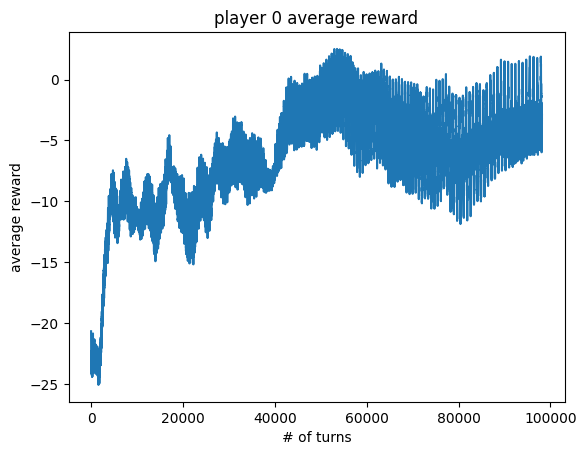

In [16]:
avg_rewards = get_conv_avg_reward(rewards, 1000)
plt.plot(np.arange(len(avg_rewards)),avg_rewards)
plt.title('player 0 average reward')
plt.xlabel('# of turns')
plt.ylabel('average reward')
plt.show()

In [17]:
print(agent_0_all_states[-10:])

[{'state': [342, 7, 2, 0.36333333333333334, 0.7710843373493976, 0.979757085020243, 0], 'action': 'quarter_pot', 'reward': 13, 'done': True, 'state_t+1': [348, 13, 0, 0.36333333333333334, 0.7710843373493976, 0.9838056680161943, 0]}, {'state': [346, 7, 2, 0.6233333333333333, 0.7713347921225383, 0.9798387096774194, 0], 'action': 'quarter_pot', 'reward': 13, 'done': True, 'state_t+1': [352, 13, 0, 0.6233333333333333, 0.7713347921225383, 0.9838709677419355, 0]}, {'state': [350, 7, 2, 0.4666666666666667, 0.7715846994535519, 0.9799196787148594, 0], 'action': 'quarter_pot', 'reward': -0.5628072303343084, 'done': False, 'state_t+1': [346, 26, 7, 0.4666666666666667, 0.7718340611353712, 0.9799196787148594, 0]}, {'state': [346, 26, 7, 0.4666666666666667, 0.7718340611353712, 0.9799196787148594, 0], 'action': 'quarter_pot', 'reward': -2.090426855527431, 'done': False, 'state_t+1': [332, 73, 7, 0.4666666666666667, 0.772082878953108, 0.9799196787148594, 0]}, {'state': [332, 73, 7, 0.4666666666666667, 

In [18]:
print(agent_1_all_states[-10:])

[{'state': [48, 13, 2, 0.5883333333333334, 0.861557478368356, 0.9153225806451613, 0], 'action': 'fold', 'reward': -1.61034947065294, 'done': True, 'state_t+1': [48, 13, 0, 0.5883333333333334, 0.861557478368356, 0.9193548387096774, 0]}, {'state': [47, 3, 1, 0.485, 0.861557478368356, 0.9156626506024096, 0], 'action': 'pot', 'reward': -0.27527576776141127, 'done': False, 'state_t+1': [44, 13, 2, 0.485, 0.8617283950617284, 0.9156626506024096, 0]}, {'state': [44, 13, 2, 0.485, 0.8617283950617284, 0.9156626506024096, 0], 'action': 'pot', 'reward': -1.1928616602994488, 'done': False, 'state_t+1': [35, 46, 7, 0.485, 0.8618988902589396, 0.9156626506024096, 0]}, {'state': [35, 46, 7, 0.485, 0.8618988902589396, 0.9156626506024096, 0], 'action': 'half_pot', 'reward': -4.220895105674973, 'done': False, 'state_t+1': [21, 109.5, 9.5, 0.485, 0.8620689655172413, 0.9156626506024096, 0]}, {'state': [21, 109.5, 9.5, 0.485, 0.8620689655172413, 0.9156626506024096, 0], 'action': 'half_pot', 'reward': -10.047

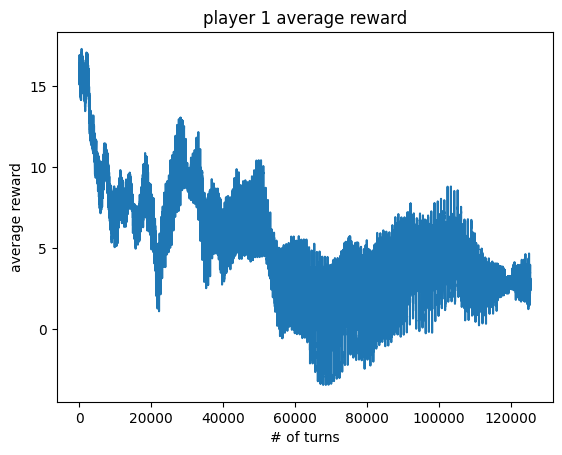

In [19]:
avg_dumb_rewards = get_conv_avg_reward(dumb_rewards, 1000)
plt.plot(np.arange(len(avg_dumb_rewards)), avg_dumb_rewards)
plt.title('player 1 average reward')
plt.xlabel('# of turns')
plt.ylabel('average reward')
plt.show()

In [20]:
all_in_hand_strength = list()
count = 0
all_actions_taken = set()
all_strengths = list()
for tup in agent_1_all_states:
    all_strengths.append(tup['state'][3])
    try:
        if tup['action'] == 'fold':
            all_in_hand_strength.append(tup['state'][3])
    except:
        count += 1

In [21]:
print(np.mean(all_strengths))
print(np.std(all_strengths))

0.48719376890884747
0.11419067590305138


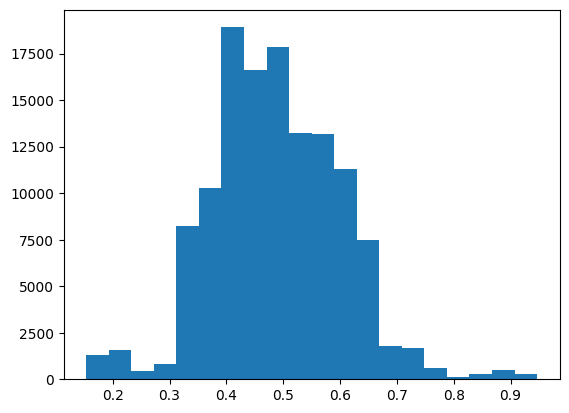

In [22]:
plt.hist(all_strengths, bins=20)
plt.show()

In [23]:
(len(all_strengths) * .2) / 7

3613.8285714285716

In [24]:
len(all_in_hand_strength)

5407

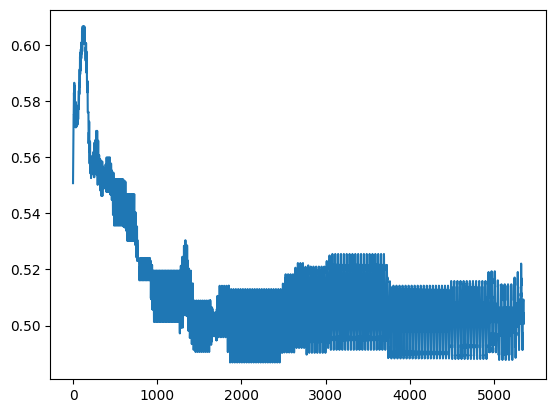

In [32]:
conv = get_conv_avg_reward(all_in_hand_strength, 50)
plt.plot(np.arange(len(conv)), conv)

In [26]:
agent_1_states

[{'state': [199, 3, 1, 0.43, 0.5, 1, 0],
  'action': 'pot',
  'reward': -0.41782381521505546,
  'done': False,
  'state_t+1': [196, 13, 2, 0.43, 1.0, 1, 0]},
 {'state': [196, 13, 2, 0.43, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': -1.810569865931907,
  'done': False,
  'state_t+1': [192, 31, 2, 0.43, 1.0, 1, 0]},
 {'state': [192, 31, 2, 0.43, 1.0, 1, 0],
  'action': 'pot',
  'reward': -4.317512757222239,
  'done': False,
  'state_t+1': [169, 114, 21, 0.43, 1.0, 1, 0]},
 {'state': [169, 114, 21, 0.43, 1.0, 1, 0],
  'action': 'fold',
  'reward': 15.877304978172107,
  'done': True,
  'state_t+1': [169, 114, 0, 0.43, 1.0, 1, 0]},
 {'state': [168, 3, 1, 0.5383333333333333, 1.0, 1, 0],
  'action': 'all_in',
  'reward': 171,
  'done': True,
  'state_t+1': [171, 171, 0, 0.5383333333333333, 1.0, 1, 0]},
 {'state': [170, 3, 1, 0.38666666666666666, 1.0, 1, 0],
  'action': 'pot',
  'reward': -0.6777967105828879,
  'done': False,
  'state_t+1': [167, 13, 2, 0.38666666666666666, 1.0, 1, 0]},

In [27]:
agent_1_states

[{'state': [199, 3, 1, 0.43, 0.5, 1, 0],
  'action': 'pot',
  'reward': -0.41782381521505546,
  'done': False,
  'state_t+1': [196, 13, 2, 0.43, 1.0, 1, 0]},
 {'state': [196, 13, 2, 0.43, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': -1.810569865931907,
  'done': False,
  'state_t+1': [192, 31, 2, 0.43, 1.0, 1, 0]},
 {'state': [192, 31, 2, 0.43, 1.0, 1, 0],
  'action': 'pot',
  'reward': -4.317512757222239,
  'done': False,
  'state_t+1': [169, 114, 21, 0.43, 1.0, 1, 0]},
 {'state': [169, 114, 21, 0.43, 1.0, 1, 0],
  'action': 'fold',
  'reward': 15.877304978172107,
  'done': True,
  'state_t+1': [169, 114, 0, 0.43, 1.0, 1, 0]},
 {'state': [168, 3, 1, 0.5383333333333333, 1.0, 1, 0],
  'action': 'all_in',
  'reward': 171,
  'done': True,
  'state_t+1': [171, 171, 0, 0.5383333333333333, 1.0, 1, 0]},
 {'state': [170, 3, 1, 0.38666666666666666, 1.0, 1, 0],
  'action': 'pot',
  'reward': -0.6777967105828879,
  'done': False,
  'state_t+1': [167, 13, 2, 0.38666666666666666, 1.0, 1, 0]},

In [28]:
agent_0_states

[{'state': [198, 7, 2, 0.37333333333333335, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': -1.7681861962246233,
  'done': False,
  'state_t+1': [194, 21, 2, 0.37333333333333335, 1.0, 1, 0]},
 {'state': [194, 21, 2, 0.37333333333333335, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': -5.30455858867387,
  'done': False,
  'state_t+1': [190, 62, 21, 0.37333333333333335, 1.0, 1, 0]},
 {'state': [190, 62, 21, 0.37333333333333335, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': 114,
  'done': True,
  'state_t+1': [231, 114, 0, 0.37333333333333335, 1.0, 1, 0]},
 {'state': [229, 171, 166, 0.565, 1.0, 1, 0],
  'action': 'fold',
  'reward': -171,
  'done': True,
  'state_t+1': [229, 171, 0, 0.565, 1.0, 1, 0]},
 {'state': [227, 7, 2, 0.7833333333333333, 1.0, 1, 0],
  'action': 'quarter_pot',
  'reward': 3.9693423443388367,
  'done': False,
  'state_t+1': [223, 26, 7, 0.7833333333333333, 1.0, 1, 0]},
 {'state': [223, 26, 7, 0.7833333333333333, 1.0, 1, 0],
  'action': 'quarter_pot',
  're

In [29]:
def single_agent_turn(agent, player_index, poker):
    """
    Get state, action, reward for agent. can't get state t+1 yet as we need to see how the other agent responds to our action first
    """
    data = {}
    state = poker.get_state(player_index)
    data['state'] = [state['stack']
                    ,state['pot_size']
                    ,state['money_to_call']
                    ,state['hand_strength']
                    ,state['af']
                    ,state['lh']
                    ,state['hand_state']]
    data['action'] = raw_action
    action, raw_action = agent.policy(data['state'])
    output = poker.step(action, player_index)
    data['reward'] = output['reward']
    data['done'] = output['done']
    return data

############################################################## LOGIC FOR HOW AN EPISODE WILL PLAY OUT 
done = False
poker.deal_hands()
data_0 = dict()
data_1 = dict()

while not done:
    agent_to_act = poker.get_whos_turn()
    if agent_to_act == 0:
        data_0 = single_agent_turn(agent_0, 0, poker)
        done = data_0['done']
        if not data_1['done']:
            data_1['state_t+1'] = poker.get_state(1)
    elif agent_to_act == 1:
        data_1 = single_agent_turn(agent_1, 1, poker)
        done = data_1['done']
        if not data_0['done']:
            data_0['state_t+1'] = poker.get_state(0)
            # data_['done'] = True


















#####################################################################################################

def ordered_turn(first_player, first_player_index, second_player, second_player_index, second_player_data, poker):
    first_player_data = dict()
    second_player_data = dict()

    first_player_state = first_player.get_state(first_player_index)
    second_player_data['state'] = [first_player_state['stack']
                                    ,first_player_state['pot_size']
                                    ,first_player_state['money_to_call']
                                    ,first_player_state['hand_strength']
                                    ,first_player_state['af']
                                    ,first_player_state['lh']
                                    ,first_player_state['hand_state']]
    cur_action_first, raw_action_first = first_player.policy(first_player_data['state'])
    output_first = poker.step(cur_action_first, first_player_index)
    print(f'PLAYER {first_player_index}\'S ACTION: {cur_action_first} CAUSED A STEP')
    print(f'PLAYER {first_player_index}\'S STATE AFTER STEP: {poker.get_state(first_player_index)}')
    print(f'PLAYER {second_player_index}\'S STATE AFTER STEP: {poker.get_state(second_player_index)}')
    first_player_data['reward_t+1'] = output_first['reward']
    done = output_first['done']
    first_player_data['done'] = done

    second_player_state = poker.get_state(second_player_index)
    second_player_data['state'] = [second_player_state['stack']
            ,second_player_state['pot_size']
            ,second_player_state['money_to_call']
            ,second_player_state['hand_strength']
            ,second_player_state['af']
            ,second_player_state['lh']
            ,second_player_state['hand_state']]
    cur_action_second, raw_action_second = second_player.policy(second_player_state)
    output_second = poker.step(cur_action_second, second_player_index)
    print(f'PLAYER {second_player_index}\'S ACTION: {cur_action_second} CAUSED A STEP')
    print(f'PLAYER {second_player_index}\'S STATE AFTER STEP: {poker.get_state(second_player_index)}')
    print(f'PLAYER {first_player_index}\'S STATE AFTER STEP: {poker.get_state(first_player_index)}')
    second_player_data['reward_t+1'] = output_second['reward']
    done = output_second['done']
    second_player_data['done'] = done
    second_player_data['state_t+1'] = [output_second['state']['stack']
                                        ,output_second['state']['pot_size']
                                        ,output_second['state']['money_to_call']
                                        ,output_second['state']['hand_strength']
                                        ,output_second['state']['af']
                                        ,output_second['state']['lh']
                                        ,output_second['state']['hand_state']]

    # Handle the state after you can see how the opponent bet into it
    first_player_next_state = poker.get_state(first_player_index)
    first_player_data['state_t+1'] = [first_player_next_state['stack']
                    ,first_player_next_state['pot_size']
                    ,first_player_next_state['money_to_call']
                    ,first_player_next_state['hand_strength']
                    ,first_player_next_state['af']
                    ,first_player_next_state['lh']
                    ,first_player_next_state['hand_state']]
    return first_player_data, second_player_data

def episode(agent_0, agent_1, poker):
    done = False
    player_0_output, player_1_output = poker.deal_hands()
    player_0_state = player_0_output['state']
    player_1_state = player_1_output['state']

    while not done:

        # data_0 = {}
        # data_1 = {}

        # data_0['state'] = [player_0_state['stack']
        #                   ,player_0_state['pot_size']
        #                   ,player_0_state['money_to_call']
        #                   ,player_0_state['hand_strength']
        #                   ,player_0_state['af']
        #                   ,player_0_state['lh']
        #                   ,player_0_state['hand_state']]

        # data_1['state'] = [player_1_state['stack']
        #                   ,player_1_state['pot_size']
        #                   ,player_1_state['money_to_call']
        #                   ,player_1_state['hand_strength']
        #                   ,player_1_state['af']
        #                   ,player_1_state['lh']
        #                   ,player_1_state['hand_state']]
        
        # Find who's turn it is to act
        player_turn = poker.get_whos_turn()
        cur_action = None
        
        if player_turn == 0:
            data_0, data_1 = ordered_turn(agent_0, 0, agent_1, 1, poker)
            print(f'STATE AFTER PLAYER 0 PLAYED: {poker.get_whos_turn()}')
        elif player_turn == 1:
            data_1, data_0 = ordered_turn(agent_1, 1, data_1, agent_0, 0, data_0, poker)
            print(f'STATE AFTER PLAYER 1 PLAYED: {poker.get_whos_turn()}')
        else:
            raise Exception('Simulator is trying to play when the hand is over')

        print(f"PLAYER 0 DATA: {data_0}")
        print(f"PLAYER 1 DATA: {data_1}")

    

#     output = poker.step()

    #     ################################################
    #     agent_1_state = poker.get_state(1)
    #     print(f"Agent 1 state: {agent_1_state}")
    #     print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")
    #     agent_1_action = agent_1.policy(agent_1_state)
    #     done = poker.step(agent_1_action, 1)


    #     if not done:
    #         agent_0_state = poker.get_state(0)
    #         print(f"agent 0 state: {agent_0_state}")
    #         print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
    #         agent_0_action = agent_0.policy(agent_0_state)
    #         done = poker.step(agent_0_action, 0)
    # print(poker.get_state(0))
    # print(poker.get_state(1))

    # agent_0_state = poker.get_state(0)
    # agent_1_state = poker.get_state(1)
    # print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
    # print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")    

NameError: name 'agent_1' is not defined

In [ ]:
config = {'monte_carlo_sample_size': 300,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)
call_agent = CallAgent({'A': ACTIONS})
raise_quarter_agent = RaiseAgent({'A': ACTIONS, 'raise_choice': 3})
episode(call_agent, raise_quarter_agent, poker)


        # [player_0_state['stack']
        #                   ,player_0_state['pot_size']
        #                   ,player_0_state['money_to_call']
        #                   ,player_0_state['hand_strength']
        #                   ,player_0_state['af']
        #                   ,player_0_state['lh']
        #                   ,player_0_state['hand_state']]

PLAYERS BETS: [2, 1]
PLAYERS BETS: [2, 1]
PLAYERS BETS: [2, 1]
{'stack': 199, 'pot_size': 3, 'money_to_call': 1, 'hand_strength': 0.515, 'af': 0.5, 'lh': 1, 'hand_state': 0}
PLAYERS BETS: [2, 6]
PLAYER 1'S ACTION: {'fold': False, 'check_or_call': False, 'raise': True, 'bet_size': 6} CAUSED A STEP
PLAYERS BETS: [2, 6]
PLAYER 1'S STATE AFTER STEP: {'stack': 194, 'pot_size': 9, 'money_to_call': 0, 'hand_strength': 0.515, 'af': 0.5, 'lh': 1, 'hand_state': 0}
PLAYERS BETS: [2, 6]
PLAYER 0'S STATE AFTER STEP: {'stack': 198, 'pot_size': 9, 'money_to_call': 4, 'hand_strength': 0.335, 'af': 1.0, 'lh': 1, 'hand_state': 0}
PLAYERS BETS: [2, 6]
PLAYERS BETS: [0, 0]
PLAYER 0'S ACTION: {'fold': False, 'check_or_call': True, 'raise': False, 'bet_size': -999} CAUSED A STEP
PLAYERS BETS: [0, 0]
PLAYER 0'S STATE AFTER STEP: {'stack': 194, 'pot_size': 13, 'money_to_call': 0, 'hand_strength': 0.655, 'af': 1.0, 'lh': 1, 'hand_state': 1}
PLAYERS BETS: [0, 0]
PLAYER 1'S STATE AFTER STEP: {'stack': 194, 'pot_

Exception: Simulator is trying to play when the hand is over

In [ ]:
config = {'monte_carlo_sample_size': 300,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = CallAgent({'A': ACTIONS})
agent_1 = CallAgent({'A': ACTIONS})

done = False

while not done:

    agent_0_state = poker.get_state(0)
    agent_1_state = poker.get_state(1)
    print(poker.get_state(0))
    print(poker.get_state(1))

    print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
    print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")

    agent_0_action = agent_0.policy(agent_0_state)
    agent_1_action = agent_1.policy(agent_1_state)

    # agent_0_action = handle_action(agent_0_action)
    # agent_1_action = handle_action(agent_1_action)

    done = poker.step(agent_1_action, 1)
    if not done:
        done = poker.step(agent_0_action, 0)
print(poker.get_state(0))
print(poker.get_state(1))


agent_0_state = poker.get_state(0)
agent_1_state = poker.get_state(1)

print(f"agent 0 reward: {poker.reward(agent_0_state, 0)}")
print(f"agent 1 reward: {poker.reward(agent_1_state, 1)}")

PLAYERS BETS: [2, 1]
PLAYERS BETS: [2, 1]
PLAYERS BETS: [2, 1]
{'stack': 198, 'pot_size': 3, 'money_to_call': 0, 'hand_strength': 0.505, 'af': 0.5, 'lh': 1, 'hand_state': 0, 'done': False}
PLAYERS BETS: [2, 1]
{'stack': 199, 'pot_size': 3, 'money_to_call': 1, 'hand_strength': 0.4266666666666667, 'af': 0.5, 'lh': 1, 'hand_state': 0, 'done': False}
agent 0 reward: 0.18201753574770385
agent 1 reward: -0.5978020933430341
PLAYERS BETS: [0, 0]
PLAYERS BETS: [0, 0]
PLAYERS BETS: [0, 0]
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.4483333333333333, 'af': 0.0, 'lh': 1, 'hand_state': 1, 'done': False}
PLAYERS BETS: [0, 0]
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.655, 'af': 0.0, 'lh': 1, 'hand_state': 1, 'done': False}
agent 0 reward: -0.7970694577907123
agent 1 reward: 1.3088432048703798
PLAYERS BETS: [0, 0]
PLAYERS BETS: [0, 0]
PLAYERS BETS: [0, 0]
{'stack': 198, 'pot_size': 4, 'money_to_call': 0, 'hand_strength': 0.285, 'af': 0.0, 'lh': 1, 'h

In [ ]:
poker.get_state(0)

PLAYERS BETS: [0, 0]


{'stack': 198,
 'pot_size': 4,
 'money_to_call': 0,
 'hand_strength': 0.5083333333333333,
 'af': 0.0,
 'lh': 1,
 'hand_state': 3,
 'done': True}

In [ ]:
list(poker.game_state.pots)

[Pot(raked_amount=0, unraked_amount=0, player_indices=(1,))]

In [ ]:
poker.game_state.statuses

[False, True]

In [ ]:
poker.get_state(1)

PLAYERS BETS: [0, 0]


{'stack': 202,
 'pot_size': 4,
 'money_to_call': 0,
 'hand_strength': 0.67,
 'af': 0.0,
 'lh': 1,
 'hand_state': 3,
 'done': True}

In [ ]:
poker.game_state.board_cards

[[Jh], [6s], [2d], [Kc], [5h]]

In [ ]:
agent_0.policy()

TypeError: CallAgent.policy() missing 1 required positional argument: 'state'

100%|██████████| 100/100 [00:33<00:00,  2.98it/s]


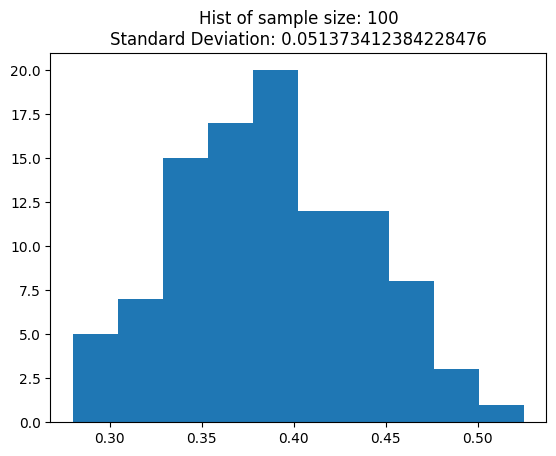

In [ ]:
sample_size = 100
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:36<00:00,  2.76it/s]


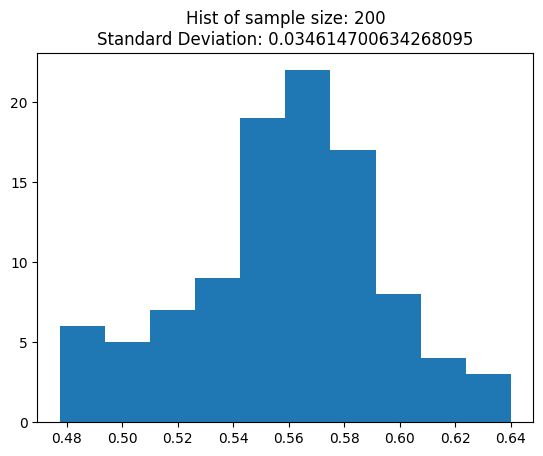

In [ ]:
sample_size = 200
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


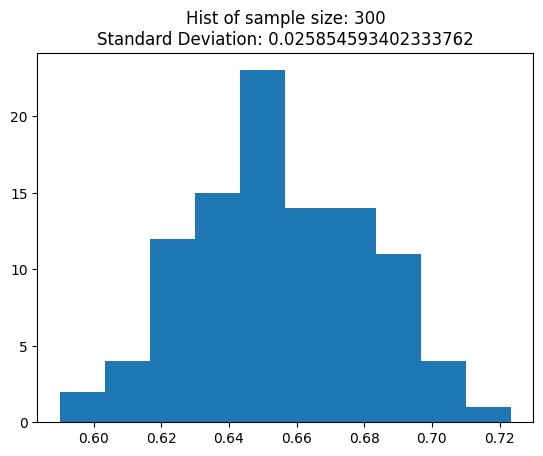

In [ ]:
sample_size = 300
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


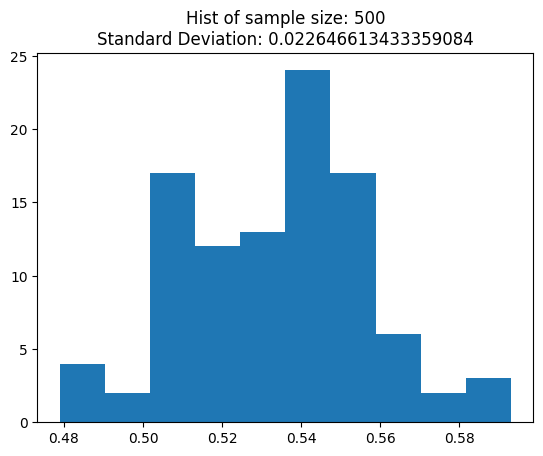

In [ ]:
sample_size = 500
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

100%|██████████| 100/100 [01:12<00:00,  1.39it/s]


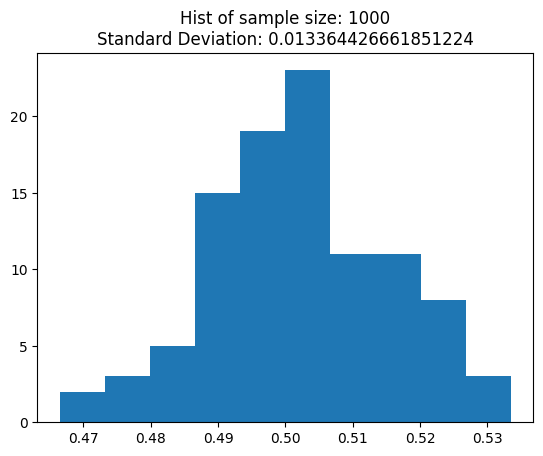

In [ ]:
sample_size = 1000
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

In [ ]:
sample_size = 3_000
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}\nStandard Deviation: {np.std(strengths)}')
plt.show()

 15%|█▌        | 15/100 [00:27<02:33,  1.81s/it]


KeyboardInterrupt: 

In [ ]:
# sample size: 500
sample_size = 500
config = {'monte_carlo_sample_size': sample_size,
          'player_0_stack': 200,
          'player_1_stack': 200}
poker = PokerEnvironment(config)

agent_0 = BaseAgent({'A': ['check_or_call']})
agent_1 = BaseAgent({'A': ['check_or_call']})
strengths = list()
for i in tqdm(range(100)):
    strengths.append(poker.get_state(1)['hand_strength'])

plt.hist(strengths)
plt.title(f'Hist of sample size: {sample_size}')
plt.show()

print(f'Standard Deviation: {np.std(strengths)}')

Standard Deviation: 0.022124646889837566


In [ ]:
poker.get_state(1)

{'stack': 199,
 'pot_size': 3,
 'money_to_call': 1,
 'hand_strength': 0.534,
 'af': -1,
 'lh': 0.75,
 'hand_state': 0}

In [ ]:
calculate_hand_strength(
            player_count= 2,
            hole_range = [['Qs','2h']],
            board_cards = [],
            hole_dealing_count=2,
            board_dealing_count=5,
            deck=Deck.STANDARD,
            hand_types=(StandardHighHand,),
            sample_count=1000,
            executor=None
        )

AttributeError: 'str' object has no attribute 'rank'

In [ ]:
state = NoLimitTexasHoldem.create_state(
    (
        Automation.ANTE_POSTING,
        Automation.BET_COLLECTION,
        Automation.BLIND_OR_STRADDLE_POSTING,
        Automation.HOLE_CARDS_SHOWING_OR_MUCKING,
        Automation.HAND_KILLING,
        Automation.CHIPS_PUSHING,
        Automation.CHIPS_PULLING
    ),
    True,
    0,
    (1,2),
    2,
    200,
    2,
    mode=Mode.CASH_GAME,
)

### First Round of Betting

In [ ]:
len(state.board_cards)

0

In [ ]:
print(state.deal_hole())
print(state.deal_hole())
print(state.deal_hole())
print(state.deal_hole())

HoleDealing(commentary=None, player_index=0, cards=(Kh,), statuses=(False,))
HoleDealing(commentary=None, player_index=1, cards=(6d,), statuses=(False,))
HoleDealing(commentary=None, player_index=0, cards=(9d,), statuses=(False,))
HoleDealing(commentary=None, player_index=1, cards=(Ah,), statuses=(False,))


In [ ]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=1, amount=1)
CheckingOrCalling(commentary=None, player_index=0, amount=0)


### Flop

In [ ]:
print(state.burn_card())

CardBurning(commentary=None, card=Ad)


In [ ]:
state.street

Street(card_burning_status=True, hole_dealing_statuses=(), board_dealing_count=3, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None)

In [ ]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(5c, Qd, 4s))


In [ ]:
#state.complete_bet_or_raise_to(198)

CompletionBettingOrRaisingTo(commentary=None, player_index=0, amount=198)

In [ ]:
state.check_or_call()

CheckingOrCalling(commentary=None, player_index=1, amount=0)

In [ ]:
list(state.pot_amounts)

[4]

In [ ]:
state.can_burn_card()

True

In [ ]:
state.burn_card()
state.deal_board()

BoardDealing(commentary=None, cards=(Ks,))

In [ ]:
state.stacks

[198, 198]

In [ ]:
state.can_burn_card()

False

In [ ]:
state.can_deal_board()

False

In [ ]:
output = state.complete_bet_or_raise_to(5)

In [ ]:
state.can_fold()

True

In [ ]:
state.board_cards

[[5c], [Qd], [4s], [Ks]]

In [ ]:
state.check_or_call()

CheckingOrCalling(commentary=None, player_index=1, amount=5)

In [ ]:
state.showdown_index

In [ ]:
state.street

Street(card_burning_status=True, hole_dealing_statuses=(), board_dealing_count=1, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None)

In [ ]:
len(state.board_cards)

4

In [ ]:
state.burn_card()
state.deal_board()

BoardDealing(commentary=None, cards=(3h,))

In [ ]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=0, amount=0)
CheckingOrCalling(commentary=None, player_index=1, amount=0)


In [ ]:
state.statuses

[True, False]

In [ ]:
state

State(automations=(<Automation.ANTE_POSTING: 'Ante posting'>, <Automation.BET_COLLECTION: 'Bet collection'>, <Automation.BLIND_OR_STRADDLE_POSTING: 'Blind or straddle posting'>, <Automation.HOLE_CARDS_SHOWING_OR_MUCKING: 'Hole cards showing or mucking'>, <Automation.HAND_KILLING: 'Hand killing'>, <Automation.CHIPS_PUSHING: 'Chips pushing'>, <Automation.CHIPS_PULLING: 'Chips pulling'>), deck=<Deck.STANDARD: (2c, 2d, 2h, 2s, 3c, 3d, 3h, 3s, 4c, 4d, 4h, 4s, 5c, 5d, 5h, 5s, 6c, 6d, 6h, 6s, 7c, 7d, 7h, 7s, 8c, 8d, 8h, 8s, 9c, 9d, 9h, 9s, Tc, Td, Th, Ts, Jc, Jd, Jh, Js, Qc, Qd, Qh, Qs, Kc, Kd, Kh, Ks, Ac, Ad, Ah, As)>, hand_types=(<class 'pokerkit.hands.StandardHighHand'>,), streets=(Street(card_burning_status=False, hole_dealing_statuses=(False, False), board_dealing_count=0, draw_status=False, opening=<Opening.POSITION: 'Position'>, min_completion_betting_or_raising_amount=2, max_completion_betting_or_raising_count=None), Street(card_burning_status=True, hole_dealing_statuses=(), board_dea

### Turn

In [ ]:
print(state.burn_card())

CardBurning(commentary=None, card=Ks)


In [ ]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(3c,))


In [ ]:
print(state.complete_bet_or_raise_to(4))
print(state.check_or_call())

CompletionBettingOrRaisingTo(commentary=None, player_index=0, amount=4)
CheckingOrCalling(commentary=None, player_index=1, amount=4)


### River

In [ ]:
print(state.burn_card())

CardBurning(commentary=None, card=5c)


In [ ]:
print(state.deal_board())

BoardDealing(commentary=None, cards=(3s,))


In [ ]:
print(state.check_or_call())
print(state.check_or_call())

CheckingOrCalling(commentary=None, player_index=0, amount=0)
CheckingOrCalling(commentary=None, player_index=1, amount=0)


In [ ]:
state.payoffs

[6, -6]

In [ ]:
state.can_deal_hole()

False

In [ ]:
state.can_burn_card()

False

In [ ]:
state.can_collect_bets()

False

In [ ]:
state.can_no_operate()

True

In [ ]:
state.can_complete_bet_or_raise_to()

False

In [ ]:
state.can_kill_hand()

False

In [ ]:
state.can_pull_chips()

False

In [ ]:
state.can_push_chips()

False

In [ ]:
state.can_win_now(0)

True

In [ ]:
state.can_show_or_muck_hole_cards()

False

In [ ]:
state.can_stand_pat_or_discard()

False

In [ ]:
state.

False